# Week1
## Load package

In [2]:
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
from ISTA import ISTAI_main
PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 64
# Load train and test
train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)

if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

d:\01_School\Q4_5LSL0_MachineLearningForsignalProcessing\SignalProcessing\5LSL0_HW\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Folders in the Fast_MRI_Knee: ['MNIST', 'test', 'train']


## Plot the example

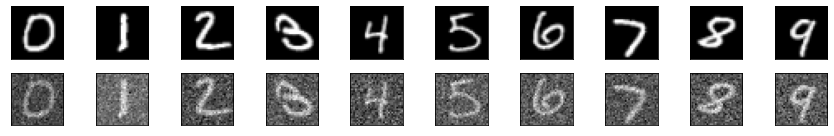

In [2]:
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    

    
plt.tight_layout()
# plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()


In [3]:
# Load data
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

Data shape and matrix shape.

In [71]:
x_clean_train.size() #60000 examples of 28x28 pixels in grayscale torch.Size([60000, 1, 32, 32])

(x_clean_example[0])
# tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          ...,
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.]]])

np.shape(torch.flatten(x_clean_example[0])) # [1, 32, 32]) --> 1, 1024

torch.Size([1024])

## a - Implement ISTA for MNIST denoising.
Input requires Stepsize - `mu`, shrinkage parameter - `shrinkage`, number of iteration `K`, and measurement Batch of MNIST images[10 images \ Matrix] `y`.

Output reconstructions `x_k`. \
In the soft thershold. \
$$
\begin{equation*}
    soft_T(x)= sign(x_i)(|x_i|-T)
\end{equation*}
$$

In [69]:
def softthreshold(self,x,shrinkage):
    # torch.sign(x) Returns a new tensor with the signs of the elements of input.
    return (torch.sign(x) * torch.maximum(torch.abs(x) - torch.tensor(shrinkage), torch.tensor(0.)))


y = x_clean_example[2]
t = y.reshape(1,-1)

# print(y.reshape(1,-1))
# print(torch.diag(t,diagonal=0))
# print(y.size(1))
# print(torch.eye(y.size(1)))

# print(torch.eye(y.size(1))*y.unsqueeze(2).expand(*y.size(), y.size(1)))
print(torch.sign(y)*torch.maximum(torch.abs(y) - torch.tensor(10), torch.tensor(0.)))
# torch.maximum(torch.abs(y)-torch.tensor(1*12),torch.tensor(0.))
A = torch.diag_embed(y.reshape(1,-1))
L = torch.linalg.norm(y) ** 2
shrinkage = 10
mu = 0.5
# torch.eye(y.shape[1])
# torch.diag(y
# torch.tensor
# x = softthreshold(x + torch.dot(y.T, mu - y*torch.tensor(x)) / L, shrinkage / L)


tensor([[[-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         ...,
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.]]])


In [11]:


# self.softthreshold(x + torch.dot(y.T, mu - y.dot(x)) / L, shrinkage / L)
MAIN = ISTAI_main()
MAIN.ISTA(mu=0.5,shrinkage=10,K=100,y= x_clean_example[0])


RuntimeError: 1D tensors expected, but got 3D and 1D tensors

$\alpha$ - step size 

$g_1 = A^T(y-Ax_1)$ 

$x_2 = x_1 + \alpha * (A^T(y-Ax_1)) $ 

$\hat{x}=sign(x_2)max(|x_2|-\alpha*\lambda,0)$  -  the last estimate

`reconstruction error error`

$error(i,1) = \frac{norm|(\hat{x} - x_1)|}{ norm|(\hat{x})|} $

## ISTA


In [7]:
def softthreshold(x,shrinkage):        
    # torch.sign(x) Returns a new tensor with the signs of the elements of input.
    return (torch.sign(x) * torch.maximum(torch.abs(x) - torch.tensor(shrinkage), torch.tensor(0.)))


In [4]:
mu = 0.01
lmbd = 0.05
K=2
y= x_clean_example[0]


Ex1 = ISTAI_main(mu,lmbd,K,y)
recon, x_hat, error,i = Ex1.ISTA(mu,lmbd,K,y)

# A = torch.diag_embed(torch.flatten(y)) # Diagnoal matrix 
# x = torch.zeros(len(torch.flatten(y))) # 1024 zero
# error = []
# for i in range(K):
#     g = A.T@(torch.flatten(y)-A@x)
#     x_2 = x +mu*g
#     x_hat = softthreshold(x_2, mu*lmbd)


# np.shape()
# (np.shape(recon[:,:]))
print(x_clean_example.shape)
print(recon.shape)

torch.Size([10, 1, 32, 32])
torch.Size([1, 1, 32, 32])


torch.Size([32, 32])


TypeError: Invalid shape (1, 1, 32, 32) for image data

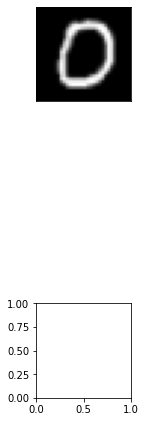

In [19]:
print(x_clean_example[1,0,:,:].shape)
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# recon = torch.zeros_like([10,32,32])

plt.figure(figsize=(20,10))
for i in range(10):
    with torch.no_grad():
        recon, x_hat, error,j = Ex1.ISTA(mu,lmbd,K,x_clean_example[i,0,:,:])
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,10,i+11)
    plt.imshow(recon.cpu(),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()
# print(recon[1, 1, 32, 32])
# for i in range(len(x_clean_example)):
#     y = x_clean_example[i].to(device)

#     with torch.no_grad():
#         recon, x_hat, error,j = Ex1.ISTA(mu,lmbd,K,y)
#         # print(recon.shape)
#         # print(np.shape(recon))

    # plt.figure(figsize=(20,10))
    # for i in range(10):
    #     plt.subplot(2,10,i+1)
    #     plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    #     plt.xticks([])
    #     plt.yticks([])

    #     plt.subplot(2,10,i+11)
    #     plt.imshow(recon.cpu(),cmap='gray')
    #     plt.xticks([])
    #     plt.yticks([])

    # plt.tight_layout()
    # # fig_path = os.path.join(os.path.abspath("."),"figure")
    # # plt.savefig(os.path.join(fig_path,"exercise_VAE_examples.png"),dpi=80,bbox_inches='tight')
    # plt.show()

recon.shape

In [8]:
recon[1,0,:,:]

IndexError: index 1 is out of bounds for dimension 0 with size 1